<a href="https://colab.research.google.com/github/Viswonathan06/CLSTM-for-SDA/blob/main/Depth_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Depth** Estimation 
We've followed the paper on exploiting temporal consistency for real-time video depth estimation. 

Find the link to the paper [here](https://openaccess.thecvf.com/content_ICCV_2019/papers/Zhang_Exploiting_Temporal_Consistency_for_Real-Time_Video_Depth_Estimation_ICCV_2019_paper.pdf)

#Importing required libraries
Note: I was doing this in the google colab notebook.So mounted by google drive.In case if you are doing this in your local machine, the respective directories are to be changed accordingly

In [ ]:
from google.colab import drive
import requests


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Dataset downloading

This below code will download the dataset from URL that was pasted at 'file_url'. The current dataset downloaded is only one video from the kitti dataset and all the ground truth depth images due to memory constraints. 

In [ ]:
#paste the url here
file_url = "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip"

r = requests.get(file_url, stream = True)  
  
#change this according ur file extension
with open("/content/gdrive/My Drive/2011_09_26_drive_0001_sync.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

In [ ]:
#paste the url here
file_url = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_depth_annotated.zip"

r = requests.get(file_url, stream = True)  
  
#change this according ur file extension
with open("/content/gdrive/My Drive/data_depth_annotated.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

## Extracting the images from the downloaded zip files

In [ ]:
#extracting
from zipfile import ZipFile
with ZipFile("/content/gdrive/MyDrive/data_depth_annotated.zip") as f:
    f.extractall()

In [ ]:
#extracting
from zipfile import ZipFile
with ZipFile("/content/gdrive/MyDrive/2011_09_26_drive_0001_sync.zip") as f:
    f.extractall()

# Importing necessary libraries

In [ ]:
import pandas as pd
import cv2 
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import os
from collections import deque
import copy
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import *

%matplotlib inline

### Listing out the frames in the directories for reference and further understanding of the structure of the folders they're kept in. 

The current format in which they're kept are:

**For ground truth depth images**

Train 
  * Video file ( date and time of video taken)
    * proj depth
      * groundtruth
        * image_02 ( we will be using this folder)
          * images in sequential and temporal order
        * image_03



**For video frames in image form**

Current format is 

* Date of video taken
  * Video file ( date and time of video taken)
    * image 00
    * image 01
    * image 02 (we'll be using this folder)
      * data 
        * images in sequential and temporal order
      * time stamps
    * .
    * .
    .



In [ ]:
frames_main = sorted(os.listdir('/content/train'))
i=0
frames_list = []
frames_main

['2011_09_26_drive_0001_sync',
 '2011_09_26_drive_0009_sync',
 '2011_09_26_drive_0011_sync',
 '2011_09_26_drive_0014_sync',
 '2011_09_26_drive_0015_sync',
 '2011_09_26_drive_0017_sync',
 '2011_09_26_drive_0018_sync',
 '2011_09_26_drive_0019_sync',
 '2011_09_26_drive_0022_sync',
 '2011_09_26_drive_0027_sync',
 '2011_09_26_drive_0028_sync',
 '2011_09_26_drive_0029_sync',
 '2011_09_26_drive_0032_sync',
 '2011_09_26_drive_0035_sync',
 '2011_09_26_drive_0039_sync',
 '2011_09_26_drive_0046_sync',
 '2011_09_26_drive_0048_sync',
 '2011_09_26_drive_0051_sync',
 '2011_09_26_drive_0052_sync',
 '2011_09_26_drive_0056_sync',
 '2011_09_26_drive_0057_sync',
 '2011_09_26_drive_0059_sync',
 '2011_09_26_drive_0060_sync',
 '2011_09_26_drive_0061_sync',
 '2011_09_26_drive_0064_sync',
 '2011_09_26_drive_0070_sync',
 '2011_09_26_drive_0084_sync',
 '2011_09_26_drive_0086_sync',
 '2011_09_26_drive_0087_sync',
 '2011_09_26_drive_0091_sync',
 '2011_09_26_drive_0093_sync',
 '2011_09_26_drive_0096_sync',
 '2011_0

In [ ]:
frames_gt = sorted(os.listdir('/content/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02'))
i=0
frames_list = []
# for video_name in videos:
#   list_frame = sorted(os.listdir('./training/image_02/%s'%video_name))
#   frames_list.append(list_frame)
  
frames_gt

['0000000005.png',
 '0000000006.png',
 '0000000007.png',
 '0000000008.png',
 '0000000009.png',
 '0000000010.png',
 '0000000011.png',
 '0000000012.png',
 '0000000013.png',
 '0000000014.png',
 '0000000015.png',
 '0000000016.png',
 '0000000017.png',
 '0000000018.png',
 '0000000019.png',
 '0000000020.png',
 '0000000021.png',
 '0000000022.png',
 '0000000023.png',
 '0000000024.png',
 '0000000025.png',
 '0000000026.png',
 '0000000027.png',
 '0000000028.png',
 '0000000029.png',
 '0000000030.png',
 '0000000031.png',
 '0000000032.png',
 '0000000033.png',
 '0000000034.png',
 '0000000035.png',
 '0000000036.png',
 '0000000037.png',
 '0000000038.png',
 '0000000039.png',
 '0000000040.png',
 '0000000041.png',
 '0000000042.png',
 '0000000043.png',
 '0000000044.png',
 '0000000045.png',
 '0000000046.png',
 '0000000047.png',
 '0000000048.png',
 '0000000049.png',
 '0000000050.png',
 '0000000051.png',
 '0000000052.png',
 '0000000053.png',
 '0000000054.png',
 '0000000055.png',
 '0000000056.png',
 '0000000057

## The idea of storing the data

We've stored the paths of all the data in a csv file in sequential order such that we can access them at any point, given our data is pre-loaded.

**Use pandas to take a look at the csv files**


In [ ]:
# Making new paths to store the csv files
train_data_path = os.path.join('content','train')
test_data_path = os.path.join('content','test')

In [ ]:
if not os.path.exists('data_files'):
  os.mkdir('data_files')
if not os.path.exists('data_files/train'):
  os.mkdir('data_files/train')
if not os.path.exists('data_files/test'):
  os.mkdir('data_files/test')






## Making CSV file with paths of both image and ground truth along with the video name

Here. we've looped over all the ground truth images, because there are fewer ground truths than the original RGB frames, and we've used that as a reference to form the csv file.

In [ ]:
train_dir = "/content/2011_09_26/"
data_dir_list = sorted(os.listdir(train_dir))

for data_dir in data_dir_list:
  video_dir = (data_dir+"/image_02")
  ground_data_dir_list = sorted(os.listdir("/content/train/"+data_dir+"/proj_depth/groundtruth/image_02"))
  video_data_dir_list = sorted( os.listdir(train_dir+video_dir+"/data"))
  train_df = pd.DataFrame(columns = ['ImagePath','GroundTruthPath','VideoName'])
  

  for img in ground_data_dir_list: # looping over every frame within the video
      img_path = os.path.join(train_dir,video_dir,"data",img)
      gt_path = os.path.join("/content/train",data_dir,"proj_depth/groundtruth/image_02",img)
      # print(img_path,gt_path)
      train_df = train_df.append({'ImagePath':img_path,'GroundTruthPath':gt_path,'VideoName':data_dir},ignore_index=True)
  file_name = '{}.csv'.format(data_dir)
  train_df.to_csv('/content/data_files/train/{}'.format(file_name))

os.path.abspath(data_dir_list[0])
  

'/content/2011_09_26_drive_0001_sync'

# Functions to generate the images in batches to feed into the data generator

In [ ]:
from collections import deque 

def file_generator(data_path,data_files,temporal_stride=1,temporal_length=16):
    '''
    data_files - list of csv files to be read.
    '''
    for f in data_files: # read all the csv files (one csv file corresponds to one vdieo) in data_files one by one
        tmp_df = pd.read_csv(os.path.join(data_path,f))
        gt_list = list(tmp_df['GroundTruthPath'])  # Load all the labels in the label_list
        total_images = len(gt_list) 
        print(total_images)
        if total_images>=temporal_length: # only if the number of frames in the video is greater tha temporal length, use that video
            num_samples = int((total_images-temporal_length)/temporal_stride)+1
            print ('num of samples from vid seq-{}: {}'.format(f,num_samples))
            img_list = list(tmp_df['ImagePath'])
            
            # print("List is : ",gt_list)
        else: # if the number of frames are less than temporal length , discard it
            print ('num of frames is less than temporal length; hence discarding this file-{}'.format(f))
            continue

        start_frame = 0
        samples = deque() # initliaze a queue to store the frames 
        groundtruth = deque()
        gtcount=0
        samp_count=0 # a counter to count the number of smaple. one smaple has as many frames as defined by temporal length
        for img,gt_img in zip(img_list,gt_list):
            samples.append(img)
            groundtruth.append(gt_img)
            if len(samples)==temporal_length: #if the queue has as many frames as temporal length, return it as one sample
                samples_c=copy.deepcopy(samples) # copy the queue as in the next stage frames would be popped
                samples_gt = copy.deepcopy(groundtruth)
                # print("gt is ", samples_gt)
                samp_count+=1
                gtcount+=1
                for t in range(temporal_stride): # pop out as many frames as described by the stride from the left to accomodate new frames
                    samples.popleft()
                    groundtruth.popleft()
                yield samples_c,samples_gt # return a sample(consisting of as many frames as defined by temporal length) 
                                                # and its corsponding label

## This is the function to load the samples to the generator

In [ ]:
def load_samples(data_cat='train',temporal_stride=1,temporal_length=16):
    data_path = os.path.join('/content/data_files',data_cat)
    data_files = os.listdir(data_path)
    # define a generator to read the samples
    file_gen = file_generator(data_path,data_files,temporal_stride,temporal_length)
    iterator = True
    data_list = []
    i=0;
    while iterator:
        try:
            x,y = next(file_gen)
            x=list(x)
            y=list(y)
            data_list.append([x,y])
            # print("Done", i, "times")
            # i = i+1
        except Exception as e:
            print ('the exception: ',e)
            iterator = False
            print ('end of data generator')
    return data_list

### Testing to see the output

In [ ]:
training_data = load_samples(data_cat='train',temporal_stride=1,temporal_length=10)
training_data

98
num of samples from vid seq-2011_09_26_drive_0001_sync.csv: 89
the exception:  
end of data generator


[[['/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000005.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000006.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000007.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000008.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000009.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000010.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000011.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000012.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000013.png',
   '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000014.png'],
  ['/content/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000005.png',
   '/content/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/000000

### Here, we've output a few general things to get an overview of what we did previously

In [ ]:
np.shape(training_data)

(89, 2, 10)

In [ ]:
training_data[1]


[['/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000006.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000007.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000008.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000009.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000010.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000011.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000012.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000013.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000014.png',
  '/content/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000015.png'],
 ['/content/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000006.png',
  '/content/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000007.png',
 

# Data generator function

Derived from keras.utils.Sequence, this custom data generator is used to feed the data into the model we'll build later. This keeps track of the backpropogation as well and gives us freedom over manipulation of the images while loading as well. 

for more info, go to this [link](https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-3-c239297cd5d6)



In [ ]:
import keras
class DataGenerator(keras.utils.Sequence):
  def __init__(self,data,batch_size,dim,is_autoencoder,shuffle):
    #Initializing the values
    self.dim = dim
    self.data  = data
    self.batch_size = batch_size
    self.list_IDs = np.arange(len(data))
    self.is_autoencoder = is_autoencoder
    self.shuffle = shuffle
    self.on_epoch_end()
    self.n = 0
    self.max = self.__len__()
  

  def on_epoch_end(self): 
    self.indexes = self.list_IDs  #Load the indexes of the data
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __len__(self): 
    return int(np.floor(len(self.data)/self.batch_size))


  def __getitem__(self, index):
    #Generate batch at position 'index' 
    print("Index is ",index)
    index = self.indexes[index*self.batch_size
      :(index+1)*self.batch_size]
    #Generate a temporary list of indexes that forms a batch based on the index selected above.
    list_IDs_temp = [self.list_IDs[k] for k in index]
    #Generate batch
    X,y = self.__data_generation(list_IDs_temp)
    return X,y

  def __data_generation(self,list_IDs_temp):
    X_data = []
    y_data = []
    for i,_ in enumerate(list_IDs_temp): #Iterating through each sequence of frames
      # seq_frames = list(self.data.iloc[i,1])
      # y = list(self.data.iloc[i,2])
      temp_data_list = []
      temp_gt_list = []
      x = self.data[i][0]
      y = self.data[i][1]
      for img, gt in zip(x,y):
        # print(img, gt)
        try:
          # print(img, gt)
          image = cv2.imread(img)
          # print("img is ", np.shape(image))
          ext_img = cv2.resize(image,self.dim)
          image_gt = cv2.imread(gt)
          
          ext_img_gt = cv2.resize(image_gt,self.dim)
          # print("this also happen")
          temp_data_list.append(ext_img)
          temp_gt_list.append(ext_img_gt) 
        except Exception as e: 
          print("Code you'd want to run in case of an exception/err")
        
      X_data.append(temp_data_list)
      y_data.append(temp_gt_list)
    X = np.array(X_data) #Converting list to array
    y = np.array(y_data)
    print("Checking... ",X,y)
    if self.is_autoencoder == True:
      return X, X
    else:
      return X, y

  def __next__(self):
        if self.n >= self.max:
           self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

## Here we've defined some parameters that we'll be following throughout. These can be changed, according to the processing power and time available.

In [ ]:
params = {
'batch_size':18,
'dim':(256,256),
'is_autoencoder':False,
'shuffle':True }

## We run it once to see what the output comes out to be
X,Y = next(DataGenerator(training_data,**params))


### Printing the images that we just put into batches

Here as we see, we've taken one batch, which consists of 10 previous images, each of size (256, 256, 3), temporally arranged, and in total we've taken 18 batches, which gives us the shape mentioned below. 



In [ ]:
print(np.shape(X))
x_0 = X[1]
y_0 = Y[1]

(18, 10, 256, 256, 3)


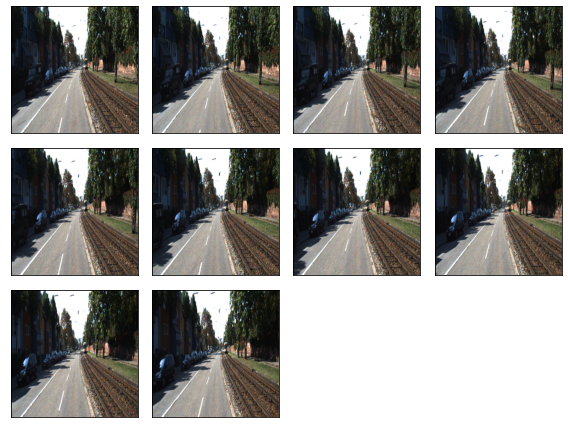

In [ ]:
num_of_images=10
fig=plt.figure(figsize=(8,8)) 
subplot_num = int(np.ceil(np.sqrt(num_of_images)))
for i in range(int(num_of_images)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(x_0[i,:,:,::-1])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

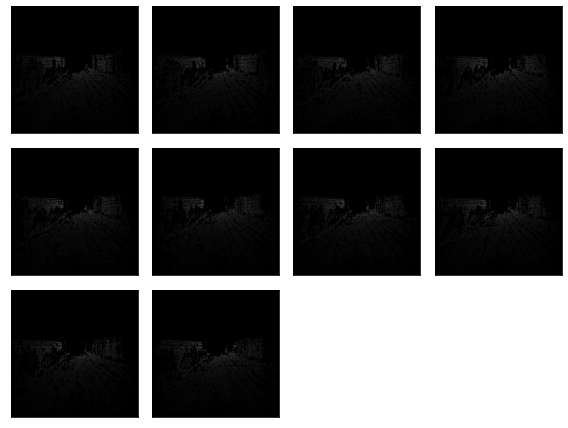

In [ ]:
num_of_images=10
fig=plt.figure(figsize=(8,8)) 
subplot_num = int(np.ceil(np.sqrt(num_of_images)))
for i in range(int(num_of_images)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(y_0[i,:,:,::-1])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

# Spatial Temporal Model 

The following model consists of a simpler version of the model shown in the paper. We've used efficientNet instead of ResNet50 for better performance and used a C-LSTM layer as a decoder for temporal consistency to certain level. 


In [ ]:
import keras
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB1

input_img = keras.Input(shape=(None,256, 256, 3))
encoded = tf.keras.layers.TimeDistributed(EfficientNetB1(input_shape=(256, 256, 3),include_top=False,weights='imagenet'))(input_img)


x = tf.keras.layers.TimeDistributed(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))(encoded)
x = tf.keras.layers.TimeDistributed(layers.UpSampling2D((2, 2)))(x)
x = tf.keras.layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
x = tf.keras.layers.TimeDistributed(layers.UpSampling2D((2, 2)))(x)
x = tf.keras.layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
x = tf.keras.layers.TimeDistributed(layers.UpSampling2D((2, 2)))(x)
x = tf.keras.layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding = 'same'))(x)
x = tf.keras.layers.TimeDistributed(layers.UpSampling2D((2, 2)))(x)
decoded = tf.keras.layers.TimeDistributed(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))(x)

clstm_out = layers.ConvLSTM2D(
            filters=1, kernel_size=(3, 3), padding="same", return_sequences=True )(decoded)


autoencoder = keras.Model(input_img, clstm_out)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

27025408/27018416 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 256, 256, 3 0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 8, 8, 1280)  6575239   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 8, 8, 512)   5898752   
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 16, 16, 512) 0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 16, 16, 128) 589952    
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 32, 32, 128) 0         
______________________________________________________________

# Loss Function

In [ ]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img




## Spatial loss

In [ ]:
def cal_spatial_loss(output, depth_gt):

  losses=[]
  
  for depth_index in range(len(output)):
    output= tf.reshape(output, [180,128,128,1])
    depth_gt= tf.reshape(depth_gt, [180,128,128,1])


    cos = tf.keras.losses.CosineSimilarity()
     # np.shape(emg)
    depth_gt_1 = output
    # img2.shape[]
    tf.dtypes.cast(depth_gt_1, tf.float32)
    tf.dtypes.cast(depth_gt, tf.float32)    # print(depth_gt_1.dtype)
    depth_gt = tf.Variable(depth_gt)
    output = tf.Variable(depth_gt_1)
    # print(depth_gt.shape)
    depth_grad = tf.image.sobel_edges(depth_gt)
    output_grad = tf.image.sobel_edges(output)

    depth_grad_dx = depth_grad[:, :, :, :,0]
    depth_grad_dy = depth_grad[:, :, :, :,1]
    output_grad_dx = output_grad[:, :, :, :,0]
    output_grad_dy = output_grad[:, :, :, :,1]

    depth_grad_dx = tf.cast(depth_grad_dx, tf.float32)
    depth_grad_dy = tf.cast(depth_grad_dy, tf.float32)
    output_grad_dx = tf.cast(output_grad_dx, tf.float32)
    output_grad_dy = tf.cast(output_grad_dy, tf.float32)




    ones = tf.ones((depth_gt.shape[0], 1, depth_gt.shape[2],depth_gt.shape[3]))
    one = tf.cast(ones, tf.float32) 

    
    depth_normal = tf.concat((-depth_grad_dx, -depth_grad_dy, ones), 1)
    output_normal = tf.concat((-output_grad_dx, -output_grad_dy, ones), 1)

    cof = 0.5

    loss_depth = tf.math.log(tf.math.abs(output - depth_gt) + cof)
    loss_dx = tf.math.log(tf.math.abs(output_grad_dx - depth_grad_dx) + cof)
    loss_dy = tf.math.log(tf.math.abs(output_grad_dy - depth_grad_dy) + cof)
    loss_normal = tf.math.abs(1 - cos(output_normal, depth_normal))

    loss_depth = tf.reduce_mean(tf.cast(loss_depth, tf.float32))
    loss_dx = tf.reduce_mean(tf.cast(loss_dx, tf.float32))
    loss_dy = tf.reduce_mean(tf.cast(loss_dy, tf.float32))
    loss_normal = tf.reduce_mean(tf.cast(loss_normal, tf.float32))

    loss = loss_depth + loss_normal + (loss_dx + loss_dy)
    losses.append(loss)

  spatial_loss = sum(losses)
  return spatial_loss

## Temporal 3DCNN Model

In [ ]:
# Create the model
from keras.models import Sequential
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,
                          MaxPooling3D, GlobalAveragePooling3D)
import tensorflow.python.keras.layers as kl

sample_shape = (10,256,256,3)
model = tf.keras.Sequential()

model.add(Conv3D(32, kernel_size=(5, 5, 5), padding='same', activation='relu', strides=2, input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(3, 3, 3),padding='same',strides = 2))
model.add(Conv3D(64, kernel_size=(5, 5, 5), padding='same', activation='relu', strides=2))
model.add(MaxPooling3D(pool_size=(3, 3, 3),padding='same', strides = 2))
model.add(Conv3D(128, kernel_size=(5, 5, 5), padding='same', activation='relu', strides=2))
model.add(MaxPooling3D(pool_size=(3, 3, 3),padding='same',strides = 2))
model.add(Conv3D(256, kernel_size=(5, 5, 5), padding='same', activation='relu', strides=2))
model.add(MaxPooling3D(pool_size=(3, 3, 3),padding='same',strides = 2))
model.add(GlobalAveragePooling3D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1 , activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 5, 128, 128, 32)   12032     
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 3, 64, 64, 32)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 2, 32, 32, 64)     256064    
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 1, 16, 16, 64)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 1, 8, 8, 128)      1024128   
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 1, 4, 4, 128)      0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 1, 2, 2, 256)     

## Compiling the model with the loss function that we've just defined. 

Currently the model is performing only on the spatial loss. For better performance, a 3DCNN will be used, in order to give better temporal consistency. However, it has to be trained separately and the balance has to be maintained. 

Follow the paper for more details.

In [ ]:
autoencoder.compile(loss = cal_spatial_loss )

In [ ]:
result = autoencoder.fit_generator(generator=DataGenerator(training_data,**params))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Streaming output truncated to the last 5000 lines.

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   ...

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]]]



 [[[[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   ...

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   [[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]]


  [[[0 0 0]
    [0 0 0]
    [0 0 0]
    ...
    [0 0 0]
    [0 0 0]
    [0 0 0]]

   [[0 0 0]
    [0 0 0]
